In [1]:
import pandas as pd

In [2]:
data=pd.read_csv('train.csv')

In [3]:
#fillna in LastWorkingDate if there is a LastWorkingDate for the employee else
employees_leaving=data[~ data.LastWorkingDate.isna()].set_index('Emp_ID')
data.LastWorkingDate.fillna(0,inplace=True)
for i in data.index:
    if(data.loc[i,'LastWorkingDate']==0):
        if(data.loc[i,'Emp_ID'] in employees_leaving.index):
            data.loc[i,'LastWorkingDate']=employees_leaving.loc[data.loc[i,'Emp_ID'],'LastWorkingDate']

In [4]:
data.head()

,MMM-YY,Emp_ID,Age,Gender,City,Education_Level,Salary,Dateofjoining,LastWorkingDate,Joining Designation,Designation,Total Business Value,Quarterly Rating
0,2016-01-01,1,28,Male,C23,Master,57387,2015-12-24,2016-03-11,1,1,2381060,2
1,2016-02-01,1,28,Male,C23,Master,57387,2015-12-24,2016-03-11,1,1,-665480,2
2,2016-03-01,1,28,Male,C23,Master,57387,2015-12-24,2016-03-11,1,1,0,2
3,2017-11-01,2,31,Male,C7,Master,67016,2017-11-06,0,2,2,0,1
4,2017-12-01,2,31,Male,C7,Master,67016,2017-11-06,0,2,2,0,1


In [5]:
#covert date columns to datetime type column
data.Dateofjoining=pd.to_datetime(data.Dateofjoining)
data['MMM-YY']=pd.to_datetime(data['MMM-YY'])

In [6]:
#new feature vintage captures time employee has spent in the organisation
data['vintage']=(data['MMM-YY']-data.Dateofjoining)
data['vintage']=data['vintage'].apply(lambda x:0 if x.days<0 else x.days)

In [7]:
#new feature promotions captures information about number of promotions employee since joining
data['promotions']=data.Designation-data['Joining Designation']

In [8]:
data.head()

,MMM-YY,Emp_ID,Age,Gender,City,Education_Level,Salary,Dateofjoining,LastWorkingDate,Joining Designation,Designation,Total Business Value,Quarterly Rating,vintage,promotions
0,2016-01-01,1,28,Male,C23,Master,57387,2015-12-24,2016-03-11,1,1,2381060,2,8,0
1,2016-02-01,1,28,Male,C23,Master,57387,2015-12-24,2016-03-11,1,1,-665480,2,39,0
2,2016-03-01,1,28,Male,C23,Master,57387,2015-12-24,2016-03-11,1,1,0,2,68,0
3,2017-11-01,2,31,Male,C7,Master,67016,2017-11-06,0,2,2,0,1,0,0
4,2017-12-01,2,31,Male,C7,Master,67016,2017-11-06,0,2,2,0,1,25,0


In [9]:
data['quarter']=data['MMM-YY'].apply(lambda x:int(x.month/4))

In [10]:
data['cumu_total_business_value_per_quarter']=data.groupby(['Emp_ID','quarter'])['Total Business Value'].cumsum()

In [11]:
#Adding the target variable using the LastWorkingDate in the new dataframe
#Since we want our model to predict the employee attrition 6 months prior to the last working date
#we will make only the last 6 months target as 1 just before the employee leaves the organisation and remaioning all as 0
new_data=pd.DataFrame()
for i in data.Emp_ID.unique():
    temp=data[data['Emp_ID']==i].reset_index().drop('index',axis=1).copy()
    temp['target']=0
    if(temp.loc[0,'LastWorkingDate']!=0):
        temp.iloc[(-6 if len(temp)>=6 else -1*len(temp)):,-1]=1
    new_data=new_data.append(temp,ignore_index=True)

In [12]:
#new feature that will capture the employee happiness score with the salary w.r.t the age group
age_group=new_data.groupby('Age')
temp=pd.DataFrame(age_group['Salary'].mean())
temp=temp.merge(age_group['Salary'].std(),left_index=True,right_index=True).rename({'Salary_x':'mean','Salary_y':'std'},axis=1)
new_data['zscore_salary_per_age']=new_data.apply(lambda x:((x['Salary']-temp.loc[x['Age'],'mean'])/temp.loc[x['Age'],'std']),axis=1)

C:\Users\Sachin\anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in double_scalars
  """


In [13]:
#std for salary for age 58 is 0 therefore z score cannot be calculated so removing 7 records
new_data=new_data[new_data['Age']!=58].reset_index().drop('index',axis=1)

In [14]:
#new feature that will capture the employee happiness score with the salary w.r.t the age group
age_ed_group=new_data.groupby(['Age','Education_Level'])
temp=pd.DataFrame(age_ed_group['Salary'].mean())
temp=temp.merge(age_ed_group['Salary'].std(),left_index=True,right_index=True).rename({'Salary_x':'mean','Salary_y':'std'},axis=1)
new_data['zscore_salary_per_ed_age']=new_data.apply(lambda x:((x['Salary']-temp.loc[(x['Age'],x['Education_Level']),'mean'])/temp.loc[(x['Age'],x['Education_Level']),'std']),axis=1)
new_data['zscore_salary_per_ed_age'].fillna(0,inplace=True)

C:\Users\Sachin\anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in double_scalars
  """


In [15]:
#new feature that will capture the employee's motivation score by 
#finding the zscore of Total Business Value w.r.t. designation and rating
designation_rating_group=new_data.groupby(['Designation','Quarterly Rating'])
temp=pd.DataFrame(designation_rating_group['Total Business Value'].mean())
temp=temp.merge(designation_rating_group['Total Business Value'].std(),left_index=True,right_index=True).rename({'Total Business Value_x':'mean','Total Business Value_y':'std'},axis=1)
new_data['zscore_business_per_desig_rat']=new_data.apply(lambda x:((x['Total Business Value']-temp.loc[(x['Designation'],x['Quarterly Rating']),'mean'])/temp.loc[(x['Designation'],x['Quarterly Rating']),'std']),axis=1)

In [16]:
#new feature that will capture the employee's motivation score by 
#finding the zscore of Total Business Value w.r.t. designation and rating
designation_rating_group=new_data.groupby(['Designation','Quarterly Rating'])
temp=pd.DataFrame(designation_rating_group['cumu_total_business_value_per_quarter'].mean())
temp=temp.merge(designation_rating_group['cumu_total_business_value_per_quarter'].std(),left_index=True,right_index=True).rename({'cumu_total_business_value_per_quarter_x':'mean','cumu_total_business_value_per_quarter_y':'std'},axis=1)
new_data['zscore_cumu_business_per_desig_rat']=new_data.apply(lambda x:((x['cumu_total_business_value_per_quarter']-temp.loc[(x['Designation'],x['Quarterly Rating']),'mean'])/temp.loc[(x['Designation'],x['Quarterly Rating']),'std']),axis=1)

In [17]:
new_data.head()

,MMM-YY,Emp_ID,Age,Gender,City,Education_Level,Salary,Dateofjoining,LastWorkingDate,Joining Designation,...,Quarterly Rating,vintage,promotions,quarter,cumu_total_business_value_per_quarter,target,zscore_salary_per_age,zscore_salary_per_ed_age,zscore_business_per_desig_rat,zscore_cumu_business_per_desig_rat
0,2016-01-01,1,28,Male,C23,Master,57387,2015-12-24,2016-03-11,1,...,2,8,0,0,2381060,1,-0.121445,-0.091609,7.124769,1.473054
1,2016-02-01,1,28,Male,C23,Master,57387,2015-12-24,2016-03-11,1,...,2,39,0,0,1715580,1,-0.121445,-0.091609,-3.351490,0.800429
2,2016-03-01,1,28,Male,C23,Master,57387,2015-12-24,2016-03-11,1,...,2,68,0,0,1715580,1,-0.121445,-0.091609,-1.063077,0.800429
3,2017-11-01,2,31,Male,C7,Master,67016,2017-11-06,0,2,...,1,0,0,2,0,0,0.250120,0.020331,-0.416457,-0.357121
4,2017-12-01,2,31,Male,C7,Master,67016,2017-11-06,0,2,...,1,25,0,3,0,0,0.250120,0.020331,-0.416457,-0.357121


In [18]:
#create final train and final_test submission file. We are seperating the last 6 month records for employees
#who are still working in the organization. That will be help us in creating final submission file
train=pd.DataFrame()
final_test=pd.DataFrame()

for i in new_data.Emp_ID.unique():
    temp=new_data[new_data['Emp_ID']==i].reset_index().drop('index',axis=1).copy()
    if(temp.loc[0,'LastWorkingDate']!=0):
        train=train.append(temp,ignore_index=True)
    else:
        train=train.append(temp.iloc[:-6,:],ignore_index=True)
        final_test=final_test.append(temp.iloc[-6:,:],ignore_index=True)

In [19]:
train.columns

Index(['MMM-YY', 'Emp_ID', 'Age', 'Gender', 'City', 'Education_Level',
       'Salary', 'Dateofjoining', 'LastWorkingDate', 'Joining Designation',
       'Designation', 'Total Business Value', 'Quarterly Rating', 'vintage',
       'promotions', 'quarter', 'cumu_total_business_value_per_quarter',
       'target', 'zscore_salary_per_age', 'zscore_salary_per_ed_age',
       'zscore_business_per_desig_rat', 'zscore_cumu_business_per_desig_rat'],
      dtype='object')

In [20]:
#creating X and Y for training
#creating X_final_test to predict the attrition of current employees using the data of last 6 months
X=pd.DataFrame()
Y=pd.DataFrame()
X_final_test=pd.DataFrame()

In [28]:
X['Age']=train.Age
t=pd.get_dummies(train.Gender).iloc[:,:-1]
X[list(t.columns)]=t
t=pd.get_dummies(train.City).iloc[:,:-1]
X[list(t.columns)]=t
t=pd.get_dummies(train.Education_Level).iloc[:,:-1]
X[list(t.columns)]=t
X['Salary']=train.Salary
#X['Joining Designation']=train['Joining Designation']
#X['Designation']=train['Designation']
X['Total Business Value']=train['Total Business Value']
X['Quarterly Rating']=train['Quarterly Rating']
X['vintage']=train.vintage
X['promotions']=train.promotions
X['cumu_total_business_value_per_quarter']=train.cumu_total_business_value_per_quarter
X['zscore_salary_per_age']=train.zscore_salary_per_age
#X['zscore_business_per_desig_rat']=train.zscore_business_per_desig_rat
X['zscore_salary_per_ed_age']=train.zscore_salary_per_ed_age
X['zscore_cumu_business_per_desig_rat']=train.zscore_cumu_business_per_desig_rat

In [29]:
X_final_test['Age']=final_test['Age']
t=pd.get_dummies(final_test.Gender).iloc[:,:-1]
X_final_test[list(t.columns)]=t
t=pd.get_dummies(final_test.City).iloc[:,:-1]
X_final_test[list(t.columns)]=t
t=pd.get_dummies(final_test.Education_Level).iloc[:,:-1]
X_final_test[list(t.columns)]=t
X_final_test['Salary']=final_test.Salary
#X_final_test['Joining Designation']=final_test['Joining Designation']
#X_final_test['Designation']=final_test['Designation']
X_final_test['Total Business Value']=final_test['Total Business Value']
X_final_test['Quarterly Rating']=final_test['Quarterly Rating']
X_final_test['vintage']=final_test.vintage
X_final_test['promotions']=final_test.promotions
X_final_test['cumu_total_business_value_per_quarter']=final_test.cumu_total_business_value_per_quarter
X_final_test['zscore_salary_per_age']=final_test.zscore_salary_per_age
#X_final_test['zscore_business_per_desig_rat']=final_test.zscore_business_per_desig_rat
X_final_test['zscore_salary_per_ed_age']=final_test.zscore_salary_per_ed_age
X_final_test['zscore_cumu_business_per_desig_rat']=final_test.zscore_cumu_business_per_desig_rat

In [30]:
Y['target']=train.target

In [31]:
from sklearn.ensemble import RandomForestClassifier

In [38]:
from sklearn.model_selection import GridSearchCV
model3=RandomForestClassifier()
grid = {'n_estimators': [700,1000],'max_depth': [None,10,15]}
gscv=GridSearchCV(estimator=model3,param_grid=grid,scoring='f1_macro',cv=3,n_jobs=-1,verbose=100)

In [39]:
gscv.fit(X,Y)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
Pickling array (shape=(4, 15460), dtype=float64).
Memmapping (shape=(9, 15460), dtype=int64) to new file C:\Users\Sachin\AppData\Local\Temp\joblib_memmapping_folder_10312_7754368617\10312-2474754561032-f737a34406414caab3d3bb43593d1a7d.pkl
Pickling array (shape=(9,), dtype=int64).
Pickling array (shape=(31, 15460), dtype=uint8).
Pickling array (shape=(44,), dtype=object).
Pickling array (shape=(1, 15460), dtype=int64).
Pickling array (shape=(1,), dtype=object).
Pickling array (shape=(10306,), dtype=int32).
Pickling array (shape=(5154,), dtype=int32).
Pickling array (shape=(4, 15460), dtype=float64).
Memmapping (shape=(9, 15460), dtype=int64) to old file C:\Users\Sachin\AppData\Local\Temp\joblib_memmapping_folder_10312_7754368617\10312-2474754561032-f737a34406414caab3d3bb43593d1a7d.pkl
Pickling array (shape=(9,), dtype=int64).
Pickling array (shape=(31, 

[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  1.0min
Pickling array (shape=(4, 15460), dtype=float64).
Memmapping (shape=(9, 15460), dtype=int64) to old file C:\Users\Sachin\AppData\Local\Temp\joblib_memmapping_folder_10312_7754368617\10312-2474754561032-f737a34406414caab3d3bb43593d1a7d.pkl
Pickling array (shape=(9,), dtype=int64).
Pickling array (shape=(31, 15460), dtype=uint8).
Pickling array (shape=(44,), dtype=object).
Pickling array (shape=(1, 15460), dtype=int64).
Pickling array (shape=(1,), dtype=object).
Pickling array (shape=(10307,), dtype=int32).
Pickling array (shape=(5153,), dtype=int32).
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:  1.1min
Pickling array (shape=(4, 15460), dtype=float64).
Memmapping (shape=(9, 15460), dtype=int64) to old file C:\Users\Sachin\AppData\Local\Temp\joblib_memmapping_folder_10312_7754368617\10312-2474754561032-f737a34406414caab3d3bb43593d1a7d.pkl
Pickling array (shape=(9,), dtype=int64).
Pickling array (shape=(31, 15460), dtyp

C:\Users\Sachin\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:739: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [40]:
print(gscv.best_score_)
print(gscv.best_params_)

0.7689381179380811
{'max_depth': 10, 'n_estimators': 1000}


In [41]:
model3=RandomForestClassifier(n_estimators=1000,max_depth=10)
model3.fit(X,Y)
pred3=model3.predict_proba(X_final_test)
pred3=pd.DataFrame(pred3[:,1],index=final_test.index,columns=['prediction'])

C:\Users\Sachin\anaconda3\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


In [42]:
from catboost import CatBoostClassifier
import lightgbm as lgb

In [ ]:
#let's find the best parameters
model=CatBoostClassifier(random_state=1,eval_metric='F1',silent=True,depth=7)
grid = {'iterations': [2000,4000, 6000],'l2_leaf_reg': [7,9]}
gscv=GridSearchCV(estimator=model,param_grid=grid,scoring='f1_macro',cv=3,n_jobs=-1,verbose=100)

In [ ]:
gscv.fit(X,Y)

In [ ]:
print(gscv.best_score_)
print(gscv.best_params_)

In [43]:
model=CatBoostClassifier(iterations=2000,random_state=1,eval_metric='F1',silent=True,depth=7,l2_leaf_reg=7)
model.fit(X,Y,early_stopping_rounds=10,verbose=100)
pred=model.predict_proba(X_final_test)
pred=pd.DataFrame(pred[:,1],index=final_test.index,columns=['prediction'])

0:	learn: 0.7388054	total: 147ms	remaining: 4m 54s
100:	learn: 0.7699564	total: 1.12s	remaining: 21.1s
200:	learn: 0.7917393	total: 2.13s	remaining: 19.1s
300:	learn: 0.8102805	total: 3.1s	remaining: 17.5s
400:	learn: 0.8292481	total: 4.05s	remaining: 16.2s
500:	learn: 0.8487965	total: 5.01s	remaining: 15s
600:	learn: 0.8645919	total: 5.95s	remaining: 13.9s
700:	learn: 0.8780919	total: 6.88s	remaining: 12.8s
800:	learn: 0.8906345	total: 7.82s	remaining: 11.7s
900:	learn: 0.9017755	total: 8.75s	remaining: 10.7s
1000:	learn: 0.9100101	total: 9.69s	remaining: 9.67s
1100:	learn: 0.9173632	total: 10.6s	remaining: 8.68s
1200:	learn: 0.9235639	total: 11.6s	remaining: 7.7s
1300:	learn: 0.9310113	total: 12.5s	remaining: 6.71s
1400:	learn: 0.9375420	total: 13.4s	remaining: 5.75s
1500:	learn: 0.9419823	total: 14.4s	remaining: 4.78s
1600:	learn: 0.9477502	total: 15.3s	remaining: 3.81s
1700:	learn: 0.9522723	total: 16.2s	remaining: 2.85s
1800:	learn: 0.9558330	total: 17.2s	remaining: 1.9s
1900:	lea

In [44]:


lgb_estimator = lgb.LGBMClassifier(boosting_type='gbdt',
                                  objective='binary',
                                  random_state = 42
                                  )
grid = {
    'num_leaves': [60],
    'feature_fraction': [0.5],
    'bagging_fraction': [0.7],
    'n_estimators':[50,100,200,300]
}

GBM_grid_search = GridSearchCV(estimator = lgb_estimator,
                     param_grid = grid,
                     scoring = 'f1_macro',
                     cv = 5,
                     n_jobs = -1,verbose=100)


lgb_model_trained = GBM_grid_search.fit(X, 
                        Y)



Fitting 5 folds for each of 4 candidates, totalling 20 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
Pickling array (shape=(4, 15460), dtype=float64).
Memmapping (shape=(9, 15460), dtype=int64) to new file C:\Users\Sachin\AppData\Local\Temp\joblib_memmapping_folder_10312_7754368617\10312-2474754561032-f737a34406414caab3d3bb43593d1a7d.pkl
Pickling array (shape=(9,), dtype=int64).
Pickling array (shape=(31, 15460), dtype=uint8).
Pickling array (shape=(44,), dtype=object).
Pickling array (shape=(1, 15460), dtype=int64).
Pickling array (shape=(1,), dtype=object).
Pickling array (shape=(12368,), dtype=int32).
Pickling array (shape=(3092,), dtype=int32).
Pickling array (shape=(4, 15460), dtype=float64).
Memmapping (shape=(9, 15460), dtype=int64) to old file C:\Users\Sachin\AppData\Local\Temp\joblib_memmapping_folder_10312_7754368617\10312-2474754561032-f737a34406414caab3d3bb43593d1a7d.pkl
Pickling array (shape=(9,), dtype=int64).
Pickling array (shape=(31, 

[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.6s
Pickling array (shape=(4, 15460), dtype=float64).
Memmapping (shape=(9, 15460), dtype=int64) to old file C:\Users\Sachin\AppData\Local\Temp\joblib_memmapping_folder_10312_7754368617\10312-2474754561032-f737a34406414caab3d3bb43593d1a7d.pkl
Pickling array (shape=(9,), dtype=int64).
Pickling array (shape=(31, 15460), dtype=uint8).
Pickling array (shape=(44,), dtype=object).
Pickling array (shape=(1, 15460), dtype=int64).
Pickling array (shape=(1,), dtype=object).
Pickling array (shape=(12368,), dtype=int32).
Pickling array (shape=(3092,), dtype=int32).
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    3.0s
Pickling array (shape=(4, 15460), dtype=float64).
Memmapping (shape=(9, 15460), dtype=int64) to old file C:\Users\Sachin\AppData\Local\Temp\joblib_memmapping_folder_10312_7754368617\10312-2474754561032-f737a34406414caab3d3bb43593d1a7d.pkl
Pickling array (shape=(9,), dtype=int64).
Pickling array (shape=(31, 15460), dtyp

C:\Users\Sachin\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Sachin\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [45]:
print(GBM_grid_search.best_score_)
print(GBM_grid_search.best_params_)

0.7584658220549764
{'bagging_fraction': 0.7, 'feature_fraction': 0.5, 'n_estimators': 50, 'num_leaves': 60}


In [46]:
model2=lgb.LGBMClassifier(boosting_type='gbdt',objective='binary',bagging_fraction=0.7,feature_fraction=0.5,num_leaves=60,num_trees=50)
model2.fit(X,Y)
pred2=model2.predict_proba(X_final_test)
pred2=pd.DataFrame(pred2[:,1],index=final_test.index,columns=['prediction'])

C:\Users\Sachin\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


In [47]:
#predicting from the output of lgbm and catboost
final_pred=pd.DataFrame(pred.merge(pred2,left_index=True,right_index=True).merge(pred3,left_index=True,right_index=True).mean(axis=1),columns=['prediction'])
final_pred['Emp_ID']=final_test.Emp_ID
pred_emp=pd.DataFrame(final_pred.groupby('Emp_ID')['prediction'].mean())
pred_emp['Target']=pred_emp['prediction'].apply(lambda x:1 if x>=0.42 else 0)
print(pred_emp['Target'].sum())

416


In [48]:
#creating submission file
subm=pd.read_csv('test.csv')
subm=subm.join(pred_emp,on='Emp_ID')
subm[['Emp_ID','Target']].to_csv('submission8.csv',index=False)

In [51]:
#let's check the importance of each feature for our algorithm top 10
print('CatBoost')
catboost_top10=pd.DataFrame([model.feature_importances_,model.feature_names_]).T.rename({0:'score',1:'feature'},axis=1).sort_values('score',ascending=False).iloc[:10,:]
print('LightGBM')
lightgbm_top10=pd.DataFrame([model2.feature_importances_,model2.feature_name_]).T.rename({0:'score',1:'feature'},axis=1).sort_values('score',ascending=False).iloc[:10,:]

CatBoost
LightGBM


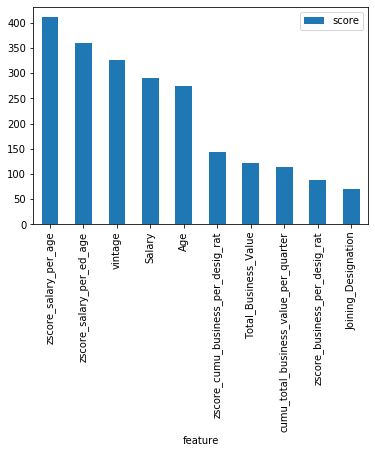

In [61]:
lightgbm_top10.set_index('feature').plot(kind='bar')
